# Implementation Roadmap
## LLM as a judge
### Must-have (ship first)
- **Strict JSON schema + retry-on-fail**  
  Ensures well-formed, consistent outputs.  

- **Multi-trace CoT (k=3–5) + self-confidence**  
  Generate multiple reasoning traces; each trace provides its own confidence score.  

- **Weighted voting by self-confidence**  
  Aggregate values using confidence weights instead of plain majority.  

- **Evidence grounding (span linking)**  
  Judge must cite exact supporting text spans; missing evidence → lower confidence.  

- **Domain validators (hard/soft rules)**  
  - Dates follow expected formats  
  - VAT ID / IBAN checksum validation  
  - `Gross ≈ Net + VAT` (within tolerance)  
  - Currency whitelist checks  

- **Per-field calibration**  
  Map raw confidence to true correctness probability (e.g., isotonic or temperature scaling).  

- **Acceptance policy**  
  Apply per-field thresholds; for documents, require all critical fields to pass.  

- **Auditing & provenance**  
  Store chosen value, calibrated confidence, cited spans, validator outcomes, and reasoning traces.  

---

### High-impact add-ons (still no training)
- **Dual-phase reasoning**  
  1. Solution reasoning → generate answer  
  2. Confidence reasoning → judge and verbalize confidence bin (0–9 or 0–1)  

- **Difficulty-aware sampling**  
  Use vote dispersion or evidence quality to stop early on easy fields or sample more traces for hard ones.  

- **Cross-judge diversity (multiple rubrics)**  
  Run the same model with different judging rubrics and combine results:  
  - *Format-strict judge*: strict regex/format checks (e.g., dates, VAT IDs)  
  - *Arithmetic-strict judge*: check totals and sums (e.g., Gross vs. Net + VAT)  
  - *Evidence-strict judge*: require supporting spans near relevant anchors (e.g., “VAT”, “Total”)  

- **Few-shot bank (prompt-only)**  
  Maintain a curated set of vendor/layout examples; update as new reviewed cases are added.  

---

### Ops & monitoring
- **Coverage vs. accuracy dashboards**  
  Track Brier, ECE, NLL, AUROC; monitor auto-accept vs. review rates.  

- **Periodic recalibration**  
  Refresh calibration mappings as new reviewed cases arrive.  

- **Fail-safes**  
  If JSON invalid or confidence unstable → deterministic re-ask at temperature=0; else route to review.  


<style>
open { color: Red }
inprogress { color: Yellow }
done { color: Green; text-decoration: line-through }
</style>

# First steps
To start things off, we need to build a simple LLM-as-a-Judge (LaaJ) setup<br>
For this we need to do prepare the following:
- <done>Access to the Azure hosted GPT5-mini</done>
- <inprogress>Access to the data located on the NAS</inprogress>

Then we need to force the LLM to create multiple reasoning paths for one input.<br>
- <done>Actively encourage the LLM to perform "slow thinking" and prepare a json output schema the data needs to fit in.</done><br>
- <done>Implement a retry option (with amount of retries as a parameter) to catch LLM errors.</done><br>
- <open>Peform validity checks for produced outputs (Valid VAT layout, isNumber for amounts, ...). If these checks fail --> confidence decrease / set to 0.</open><br>
- <done>Query the LLM to rate its own output using numeric and written bins (10 bins, [0.0; 0.1], [0.1; 0.2], ...)</done><br>
- <inprogress>Implement weighted majority voting based on confidence (Borda voting with exponent)</inprogress><br>

<open>Visualize the results of perceived confidence and actual correctness in a bar chart (should be x=y for perfect prediction)</open><br>


# LLM Setup

In [1]:
# --- setup: remove retries, unused vars, fix concurrent name, simpler mkdir ---
from datetime import datetime
import os
from pathlib import Path
from dotenv import load_dotenv
from openai import AsyncOpenAI
import logging
import json

load_dotenv(override=True)

DOCUMENT_STORAGE = Path(os.getenv("DOCUMENT_STORAGE"))
TIMESTAMP = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

client = AsyncOpenAI(api_key=API_KEY, base_url=ENDPOINT)

CONCURRENT_TASKS = 15  # fixed typo

# Pricing (EUR per 1M tokens)
PRICE_INPUT_EUR_PER_MTOK = 0.22
PRICE_CACHED_INPUT_EUR_PER_MTOK = 0.03
PRICE_OUTPUT_EUR_PER_MTOK = 1.73

logging_path = Path("../Logs")
logging_path.mkdir(parents=True, exist_ok=True)

logging.basicConfig(
    filename=f"{logging_path}/{DEPLOYMENT_NAME}_{TIMESTAMP}.log",
    filemode="a",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    force=True,
)
for noisy in ["httpx", "openai", "azure", "urllib3"]:
    logging.getLogger(noisy).setLevel(logging.WARNING)

with open("../Prompts/system_prompt.txt", "r", encoding="utf-8") as f:
    system_prompt = f.read()
with open("../Prompts/schema.json", "r", encoding="utf-8") as f:
    schema = json.load(f)
formatted_schema = json.dumps(schema, indent=2)
system_prompt = system_prompt.replace("formatted_schema_representation", formatted_schema)


# Helper Functions

## Fuzzy Comparison

In [2]:
import re
from typing import Any, Optional

COMPARE_FIELDS = [
    "Sender.VatId",
    "GrandTotal.Amount",
    "Net.Amount",
    "Vat.Amount",
    "Vat.Rate",
    "Invoice.Date",
]

NUMERIC_FIELDS = {
    "GrandTotal.Amount",
    "Net.Amount",
    "Vat.Amount",
    "Vat.Rate",
}


_TRAILING_RE = re.compile(r"[ \t\r\n\.,;:\-\u2013\u2014\u2011]+$")  # remove trailing whitespace, punctuation, and hyphen-like dashes

def strip_trailing_punct(x: Any) -> Optional[str]:
    if x is None:
        return None
    s = str(x).strip()
    if not s:
        return None
    return _TRAILING_RE.sub("", s)

def parse_number(x: Any) -> Optional[float]:
    """
    Improved numeric parsing:
    - Rightmost of ',' or '.' is treated as the decimal separator.
    """
    s = strip_trailing_punct(x)
    if s is None:
        return None

    # keep only digits, separators, minus
    s = re.sub(r"[^0-9,.\-]", "", s)
    if not s:
        return None

    last_dot = s.rfind(".")
    last_comma = s.rfind(",")

    if last_dot != -1 and last_comma != -1:
        # both present: rightmost decides decimal
        if last_comma > last_dot:
            # comma is decimal, dots are thousands
            s = s.replace(".", "")
            s = s.replace(",", ".")
        else:
            # dot is decimal, commas are thousands
            s = s.replace(",", "")
    elif last_comma != -1:
        # only comma present -> decimal comma
        s = s.replace(".", "")  # any stray dots treated as thousands
        s = s.replace(",", ".")

    try:
        val = float(s)
    except ValueError:
        return None

    return val


def normalize_value(field: str, value: Any):
    if field in NUMERIC_FIELDS:
        return parse_number(value)
    # Special-case: for VAT IDs, remove all internal whitespace before compare
    if field == "Sender.VatId":
        s = strip_trailing_punct(value)
        if s is None:
            return None
        return re.sub(r"\s+", "", s)
    # non-numeric: only remove trailing whitespace/punctuation
    return strip_trailing_punct(value)


def _round_numeric(val):
    if val is None:
        return None
    return round(float(val), 2)

def _normalize_element(field: str, value: Any):
    v = normalize_value(field, value)
    if field in NUMERIC_FIELDS:
        v = _round_numeric(v)
    return v

def normalize_for_compare(field: str, value):
    """Normalize values for comparison.
    - For numeric fields: parse and round
    - For text: trim trailing punctuation/whitespace; special-case VAT removes internal whitespace
    - For lists: apply element-wise normalization and drop Nones/empties
    """
    if isinstance(value, list):
        normed_list = []
        for item in value:
            nv = _normalize_element(field, item)
            if nv is None or (isinstance(nv, str) and nv == ""):
                continue
            normed_list.append(nv)
        return normed_list
    return _normalize_element(field, value)


In [3]:
import time
from collections import defaultdict, Counter

async def _timed_request(**kwargs):
    start = time.time()
    resp = await client.responses.create(**kwargs)
    runtime = round(time.time() - start, 2)
    usage = getattr(resp, "usage", None)
    # Try to read cached input tokens if available on this client/endpoint
    return resp, {
        "runtime_sec": runtime,
        "input_tokens": getattr(usage, "input_tokens", None),
        "cached_input_tokens": getattr(usage, "cached_input_tokens", None),
        "output_tokens": getattr(usage, "output_tokens", None),
        "total_tokens": getattr(usage, "total_tokens", None),
    }



CONFIDENCE_CLASSES = [
    "Almost no chance",
    "Highly unlikely",
    "Chances are slight",
    "Unlikely",
    "Less than even",
    "Better than even",
    "Likely",
    "Very good chance",
    "Highly likely",
    "Almost certain"
]

def score_to_verbal(score: float) -> str:
    s = 0.0 if score is None else float(score)
    s = max(0.0, min(1.0, s))
    bounds = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
    idx = max(i for i, b in enumerate(bounds) if s >= b)
    return CONFIDENCE_CLASSES[idx]


def _extract_reasoning_text(resp) -> str:
    chunks = []
    for item in getattr(resp, "output", []) or []:
        if getattr(item, "type", "") == "reasoning":
            summary = getattr(item, "summary", None)
            if isinstance(summary, list):
                for seg in summary:
                    t = getattr(seg, "text", None)
                    if t:
                        chunks.append(t)
            for seg in getattr(item, "content", []) or []:
                t = getattr(seg, "text", None)
                if t:
                    chunks.append(t)
    if chunks:
        return "\n".join(chunks).strip()
    return getattr(resp, "output_text", "") or ""

def _coerce_answer_dict(ans: dict) -> dict:
    if isinstance(ans, dict) and "properties" in ans and "values" in ans:
        v = ans.get("values")
        return v if isinstance(v, dict) else ans
    return ans if isinstance(ans, dict) else {}



def _gt_path_for_txt(txt_path):
    p = Path(txt_path)
    stem_id = p.stem.split("_")[0]  
    return sorted(p.parent.glob(f"{stem_id}_*.json"))[0]


def _norm_scalar(v):
    if v is None:
        return ""
    if isinstance(v, (int, float, bool)):
        return str(v)
    return str(v).strip()


def _flatten_gt(gt: dict) -> dict:
    out = defaultdict(list)
    for node in gt.get("DocumentEssentials", []) or []:
        label = node.get("Label")
        items = node.get("Items")
        if items:
            # e.g., "Vat.Item" group: collect sub-labels into lists
            for sub in items:
                sub_label = sub.get("Label")
                sub_text = sub.get("Text")
                if sub_label:
                    out[sub_label].append(_norm_scalar(sub_text))
        else:
            text = node.get("Text")
            if label:
                out[label].append(_norm_scalar(text))
    # collapse singletons to scalars
    flat = {}
    for k, vals in out.items():
        vals = [v for v in vals if v != ""]
        flat[k] = vals[0] if len(vals) == 1 else vals
    return flat

def _to_multiset(v):
    if isinstance(v, list):
        return Counter(v)
    return Counter([v])

def compare_with_ground_truth(answer_dict: dict, txt_path: str | Path):
    gt_path = _gt_path_for_txt(txt_path)
    if not Path(gt_path).exists():
        return {
            "ground_truth_path": str(gt_path),
            "per_field": {},
            "summary": {"matched": 0, "total": 0, "all_match": False, "note": "ground truth not found"},
        }

    gt_json = json.loads(Path(gt_path).read_text(encoding="utf-8"))
    gt_flat = _flatten_gt(gt_json)

    # Only check the six specified fields
    fields_to_check = [f for f in COMPARE_FIELDS if f in gt_flat or f in answer_dict]
    per_field = {}
    num_matched = 0

    for field in fields_to_check:
        llm_raw = answer_dict.get(field, None)
        gt_raw = gt_flat.get(field, None)

        llm_norm = normalize_for_compare(field, llm_raw)
        gt_norm = normalize_for_compare(field, gt_raw)

        # Multiset comparison to allow multiple items irrespective of order
        if isinstance(llm_norm, list) or isinstance(gt_norm, list):
            is_match = _to_multiset(llm_norm) == _to_multiset(gt_norm)
        else:
            is_match = llm_norm == gt_norm
            
        if is_match:
            num_matched += 1

        # keep original shapes in output
        per_field[field] = [is_match, llm_raw, gt_raw]

    total = len(fields_to_check)
    return {
        "ground_truth_path": str(gt_path),
        "per_field": per_field,
        "summary": {"matched": num_matched, "total": total, "all_match": num_matched == total},
    }



# Test Reasoning path setup

In [4]:
from pathlib import Path
import json
from datetime import datetime

def _postprocess_final_payload(payload: dict) -> dict:
    """
    Expecting payload shape:
    {
      "answer": {...},                       # dict conforming to your schema
      "confidence": {"field.path": float}    # 0..1 per field that appears in 'answer'
    }
    Returns lean record with numeric + verbal per field.
    """
    answer = _coerce_answer_dict(payload.get("answer", {}))
    conf_num = payload.get("confidence", {}) or {}

    # Build verbal per field for fields present in numeric dict
    conf_verbal = {k: score_to_verbal(v) for k, v in conf_num.items()}

    return {
        "answer": answer,
        "confidence_numeric": conf_num,
        "confidence_verbal": conf_verbal,
    }

async def run_three_step_invoice_with_reasoning(invoice_txt_path: str, output_dir: Path):
    text = Path(invoice_txt_path).read_text(encoding="utf-8")

    # Step 1 — SOLUTION REASONING
    resp1, log1 = await _timed_request(
        model=DEPLOYMENT_NAME,
        instructions=system_prompt,
        input=(
            "Step 1 — SOLUTION REASONING:\n"
            "Reason step by step to extract the structured invoice data from the text below. "
            "Use slow thinking (explore alternatives, verify fields). "
            "Do NOT output the final answer yet.\n\n"
            f"--- INVOICE TEXT START ---\n{text}\n--- INVOICE TEXT END ---"
        ),
        reasoning={"effort": "low"},
        max_output_tokens=4000,
        text={"verbosity": "low"},
    )
    step1_notes = _extract_reasoning_text(resp1)

    # Step 2 — CONFIDENCE REASONING (no previous_response_id; pass notes explicitly)
    resp2, log2 = await _timed_request(
        model=DEPLOYMENT_NAME,
        instructions=system_prompt,
        input=(
            "Step 2 — CONFIDENCE REASONING:\n"
            "Evaluate, step by step, how likely each extracted field is correct, based on internal consistency "
            "and evidence in the text. Do NOT output the final answer yet.\n\n"
            f"--- INVOICE TEXT START ---\n{text}\n--- INVOICE TEXT END ---\n\n"
            "--- INTERNAL NOTES FROM STEP 1 (for your reference) ---\n"
            f"{step1_notes}\n"
        ),
        reasoning={"effort": "low"},
        max_output_tokens=2000,
        text={"verbosity": "low"},
    )
    step2_notes = _extract_reasoning_text(resp2)

    # Step 3 — FINAL JSON WITH PER-FIELD NUMERIC CONFIDENCE (no previous_response_id; pass both notes)
    resp3, log3 = await _timed_request(
        model=DEPLOYMENT_NAME,
        instructions=system_prompt,
        input=(
            "Step 3 — FINAL OUTPUT:\n"
            "Return ONLY a single valid JSON object with this structure and nothing else:\n"
            "{\n"
            '  "answer": <your final extracted invoice data strictly following this schema: '
            f"{json.dumps(schema)}"
            ">,\n"
            '  "confidence": {\n'
            "    // For every field you output in 'answer', provide a numeric confidence in [0,1].\n"
            '    // Use the exact same field keys as in \"answer\". For nested fields, use dot-notation keys.\n'
            '    // Example: \"Net.Amount\": 0.82\n'
            "  }\n"
            "}\n"
            "Do not include comments in the actual JSON. Do not include any extra keys. No markdown.\n\n"
            f"--- INVOICE TEXT START ---\n{text}\n--- INVOICE TEXT END ---\n\n"
            "--- INTERNAL NOTES FROM STEP 1 ---\n"
            f"{step1_notes}\n\n"
            "--- INTERNAL NOTES FROM STEP 2 ---\n"
            f"{step2_notes}\n"
        ),
        reasoning={"effort": "low"},
        max_output_tokens=2000,
        text={"verbosity": "low"},
    )

    try:
        payload = json.loads(resp3.output_text)
    except Exception:
        return None  # skip this trace

    processed = _postprocess_final_payload(payload)
    evaluation = compare_with_ground_truth(processed['answer'], invoice_txt_path)

    # Cost estimation (EUR) per trace
    itok = (log1.get("input_tokens") or 0) + (log2.get("input_tokens") or 0) + (log3.get("input_tokens") or 0)
    itok_cached = (log1.get("cached_input_tokens") or 0) + (log2.get("cached_input_tokens") or 0) + (log3.get("cached_input_tokens") or 0)
    otok = (log1.get("output_tokens") or 0) + (log2.get("output_tokens") or 0) + (log3.get("output_tokens") or 0)

    # Bill input minus cached at input rate, cached at cached rate
    billable_input = max(0, itok - itok_cached)
    cost_eur = (
        (billable_input / 1_000_000.0) * PRICE_INPUT_EUR_PER_MTOK
        + (itok_cached / 1_000_000.0) * PRICE_CACHED_INPUT_EUR_PER_MTOK
        + (otok / 1_000_000.0) * PRICE_OUTPUT_EUR_PER_MTOK
    )

    lean_record = {
        "input_path": str(invoice_txt_path),
        "answer": processed["answer"],
        "confidence_numeric": processed["confidence_numeric"],
        "confidence_verbal": processed["confidence_verbal"],
        "reasoning": {
            "step1": step1_notes,
            "step2": step2_notes,
        },
        "llm_logs": {
            "step1": log1,
            "step2": log2,
            "step3": log3,
        },
        "evaluation": evaluation,
        "cost": {
            "input_tokens": itok,
            "cached_input_tokens": itok_cached,
            "output_tokens": otok,
            "eur_estimate": round(cost_eur, 6),
        },
    }

    out_path = output_dir / (Path(invoice_txt_path).stem + ".json")
    out_path.write_text(json.dumps(lean_record, ensure_ascii=False, indent=2), encoding="utf-8")
    return lean_record

# Add weighted majority voting

In [5]:
# Concurrent weighted majority voting with bounded parallelism
import asyncio
from collections import defaultdict
import json
from pathlib import Path

def _key(v):
    # hashable key for dict/list/float/string values
    if isinstance(v, (str, int, float, bool)) or v is None:
        return v
    return json.dumps(v, sort_keys=True, ensure_ascii=False)

def _weighted_majority(flat_runs):
    consensus_result = {}
    debug_info = {}

    all_fields = set().union(*[r["answer"].keys() for r in flat_runs])
    for field in all_fields:
        sum_confidence = defaultdict(float)
        vote_count = defaultdict(int)

        for run in flat_runs:
            if field in run["answer"]:
                value = run["answer"][field]
                confidence = float(run["confidence_numeric"].get(field, 1.0) or 1.0)
                key = _key(value)
                sum_confidence[key] += confidence
                vote_count[key] += 1

        if sum_confidence:
            # pick value with max accumulated confidence; tie-break by count
            best_key = max(sum_confidence, key=lambda k: (sum_confidence[k], vote_count[k]))
            try:
                best_value = json.loads(best_key)
            except Exception:
                best_value = best_key

            consensus_result[field] = {
                "value": best_value,
                "sum_confidence": round(sum_confidence[best_key], 2),
                "vote_count": vote_count[best_key],
                "avg_confidence": round(sum_confidence[best_key] / max(1, vote_count[best_key]), 2),
            }
            debug_info[field] = {
                "sum_conf_per_value": {k: round(v, 2) for k, v in sum_confidence.items()},
                "counts": dict(vote_count),
            }

    return consensus_result, debug_info

async def run_self_consistent_invoice(
    invoice_txt_path: str,
    n_paths: int = 5,
    sem: asyncio.Semaphore | None = None,
    base_dir: Path | None = None,
):
    stem = Path(invoice_txt_path).stem                           # e.g., "274202_grid_concat"
    file_id = stem.split("_")[0]                                 # e.g., "274202"

    # Use provided base_dir or create a local one (only for standalone usage)
    root_out = base_dir or Path(f"../Output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
    root_out.mkdir(parents=True, exist_ok=True)

    # Per-file subfolder by ID
    file_dir = root_out / file_id
    file_dir.mkdir(parents=True, exist_ok=True)

    local_sem = sem or asyncio.Semaphore(CONCURRENT_TASKS)

    async def _bounded_run(out_dir: Path):
        async with local_sem:
            return await run_three_step_invoice_with_reasoning(invoice_txt_path, out_dir)

    tasks = []
    for i in range(n_paths):
        out_dir = file_dir / f"rep_{i+1}"
        out_dir.mkdir(parents=True, exist_ok=True)
        tasks.append(asyncio.create_task(_bounded_run(out_dir)))

    runs = await asyncio.gather(*tasks)
    runs = [r for r in runs if r is not None]  # drop failed traces

    flat_runs = [{"answer": r["answer"], "confidence_numeric": r.get("confidence_numeric", {})} for r in runs]
    final_answer, debug = _weighted_majority(flat_runs)

    # Aggregate cost across usable runs
    total_input = sum((r.get("cost", {}).get("input_tokens", 0) or 0) for r in runs)
    total_cached = sum((r.get("cost", {}).get("cached_input_tokens", 0) or 0) for r in runs)
    total_output = sum((r.get("cost", {}).get("output_tokens", 0) or 0) for r in runs)
    billable_input = max(0, total_input - total_cached)
    total_cost_eur = (
        (billable_input / 1_000_000.0) * PRICE_INPUT_EUR_PER_MTOK
        + (total_cached / 1_000_000.0) * PRICE_CACHED_INPUT_EUR_PER_MTOK
        + (total_output / 1_000_000.0) * PRICE_OUTPUT_EUR_PER_MTOK
    )

    consensus = {
        "input_path": str(invoice_txt_path),
        "n_paths": n_paths,
        "final_answer": final_answer,
        "runs": runs,
        "vote_debug": debug,
        "cost": {
            "input_tokens": int(total_input),
            "cached_input_tokens": int(total_cached),
            "output_tokens": int(total_output),
            "eur_estimate": round(total_cost_eur, 6),
        }
    }
    # Write consensus into the ID subfolder
    (file_dir / "consensus.json").write_text(
        json.dumps(consensus, ensure_ascii=False, indent=2), encoding="utf-8"
    )
    return consensus

In [ ]:
# Progress bar for folder runner (async-friendly)
import asyncio
from pathlib import Path
from typing import Optional
from datetime import datetime

from tqdm.auto import tqdm  # pip install tqdm

async def run_invoices_in_folder(
    folder_path: str | Path,
    n_paths: int = 5,
    max_files: Optional[int] = None,
):
    folder = Path(folder_path)
    assert folder.is_dir(), f"Not a folder: {folder}"

    files = sorted(folder.rglob("*_grid_concat.txt"))
    if max_files is not None:
        files = files[:max_files]

    run_dir = Path(f"../Output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
    run_dir.mkdir(parents=True, exist_ok=True)

    shared_sem = asyncio.Semaphore(CONCURRENT_TASKS)

    async def _run_file(txt_path: Path):
        return str(txt_path), await run_self_consistent_invoice(
            str(txt_path),
            n_paths=n_paths,
            sem=shared_sem,
            base_dir=run_dir,
        )

    results = {}
    coros = [_run_file(p) for p in files]
    with tqdm(total=len(coros), desc="Invoices", unit="file") as pbar:
        for fut in asyncio.as_completed(coros):
            p, consensus = await fut
            results[p] = consensus
            pbar.update(1)

    return results

# Example:
results = await run_invoices_in_folder("../Documents", n_paths=3, max_files=None)

Invoices:  99%|█████████▉| 149/150 [08:49<00:04,  4.85s/file]

# Visualization

## Individual Runs

In [6]:
import json
import math
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

def _make_bins(min_conf: float = 0.90, max_conf: float = 1.00, bin_width: float = 0.01):
    min_conf = float(min_conf); max_conf = float(max_conf); bin_width = float(bin_width)
    assert 0.0 <= min_conf < max_conf <= 1.0, "Range must be within [0,1] and min<max"
    assert bin_width > 0, "bin_width must be > 0"
    # Left edges; ensure we include max bin by not stepping past max_conf
    edges = np.arange(min_conf, max_conf, bin_width)
    # If max_conf is exactly on a step, last edge < max_conf; we want last bin to include max_conf
    num_bins = len(edges)
    centers = edges + bin_width / 2.0
    # Clip the last center to max_conf if it goes beyond
    if centers.size > 0:
        centers[-1] = min(centers[-1], max_conf)
    labels = [f"{c:.2f}" for c in centers]
    # If the last bin should explicitly read max_conf (e.g., 1.00), set label
    if labels:
        labels[-1] = f"{max_conf:.2f}"
    return edges, centers, labels, num_bins, bin_width, min_conf, max_conf

def _bin_index_conf(c: float, edges: np.ndarray, min_conf: float, max_conf: float, bin_width: float, num_bins: int):
    if c is None:
        return None
    c = max(0.0, min(1.0, float(c)))
    if c < min_conf:
        return None
    if c >= max_conf:
        return num_bins - 1  # include max_conf in the last bin
    return int(math.floor((c - min_conf) / bin_width))

def plot_calibration_for_run(run_dir: str | Path, min_conf: float = 0.90, max_conf: float = 1.00, bin_width: float = 0.01):
    run_dir = Path(run_dir)
    assert run_dir.is_dir(), f"Not a directory: {run_dir}"

    consensus_files = sorted(run_dir.glob("*/consensus.json"))
    assert consensus_files, f"No consensus.json files under {run_dir}"

    edges, centers, labels, num_bins, bw, minc, maxc = _make_bins(min_conf, max_conf, bin_width)
    stats = defaultdict(lambda: [ {"correct": 0, "total": 0} for _ in range(num_bins) ])

    for cf in consensus_files:
        data = json.loads(cf.read_text(encoding="utf-8"))
        input_path = data.get("input_path")
        final_answer = data.get("final_answer", {}) or {}
        answer_values, per_field_conf = {}, {}
        for field, entry in final_answer.items():
            if isinstance(entry, dict) and "value" in entry:
                answer_values[field] = entry.get("value")
                per_field_conf[field] = entry.get("avg_confidence")
            else:
                answer_values[field] = entry
                per_field_conf[field] = None
        evaluation = compare_with_ground_truth(answer_values, input_path)
        for field, triple in (evaluation.get("per_field", {}) or {}).items():
            try:
                is_match = bool(triple[0])
            except Exception:
                continue
            idx = _bin_index_conf(per_field_conf.get(field), edges, minc, maxc, bw, num_bins)
            if idx is None:
                continue
            stats[field][idx]["total"] += 1
            stats[field][idx]["correct"] += 1 if is_match else 0

    for field, bin_counts in stats.items():
        x_pos = centers
        acc_pct = []
        x_conf, y_acc = [], []
        for i in range(num_bins):
            c = bin_counts[i]
            if c["total"] > 0:
                acc = 100.0 * c["correct"] / c["total"]
                acc_pct.append(acc)
                x_conf.append(float(x_pos[i]))
                y_acc.append(acc)
            else:
                acc_pct.append(0.0)

        plt.figure(figsize=(8, 4))
        plt.bar(x_pos, acc_pct, width=bw * 0.9, color="#4C78A8", alpha=0.8, label="Bin accuracy (consensus)")

        if len(x_conf) >= 2:
            m, b0 = np.polyfit(np.array(x_conf), np.array(y_acc), 1)
            x_line = np.linspace(minc, maxc, 100)
            y_line = m * x_line + b0
            plt.plot(x_line, y_line, color="#E45756", linewidth=2, label="Linear fit")

        x_ref = np.linspace(minc, maxc, 100)
        y_ref = 100.0 * x_ref
        plt.plot(x_ref, y_ref, color="#72B7B2", linestyle="--", linewidth=1.5, label="Ideal")

        plt.ylim(0, 100)
        plt.xlabel(f"Model confidence (bins, {int(bw*100)}% from {minc:.2f} to {maxc:.2f})")
        plt.ylabel("Accuracy (%)")
        plt.title(f"Calibration — {field}")
        plt.grid(axis="y", linestyle="--", alpha=0.4)
        plt.xticks(x_pos, labels)
        plt.legend(loc="lower right")

        out_path = run_dir / f"calibration_{field.replace('.', '_')}_{int(minc*100)}_{int(maxc*100)}_{int(bw*100)}pct.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=150)
        plt.show()
        print(f"Saved: {out_path}")

def plot_calibration_for_individual_runs(run_dir: str | Path, min_conf: float = 0.90, max_conf: float = 1.00, bin_width: float = 0.01):
    run_dir = Path(run_dir)
    assert run_dir.is_dir(), f"Not a directory: {run_dir}"

    run_files = sorted(run_dir.glob("*/*/*.json"))
    if not run_files:
        print(f"No individual run files under {run_dir}")
        return

    edges, centers, labels, num_bins, bw, minc, maxc = _make_bins(min_conf, max_conf, bin_width)
    stats = defaultdict(lambda: [ {"correct": 0, "total": 0} for _ in range(num_bins) ])

    for rf in run_files:
        try:
            data = json.loads(rf.read_text(encoding="utf-8"))
        except Exception:
            continue
        input_path = data.get("input_path")
        answer = data.get("answer", {}) or {}
        conf = data.get("confidence_numeric", {}) or {}
        evaluation = compare_with_ground_truth(answer, input_path)
        for field, triple in (evaluation.get("per_field", {}) or {}).items():
            try:
                is_match = bool(triple[0])
            except Exception:
                continue
            idx = _bin_index_conf(conf.get(field), edges, minc, maxc, bw, num_bins)
            if idx is None:
                continue
            stats[field][idx]["total"] += 1
            stats[field][idx]["correct"] += 1 if is_match else 0

    for field, bin_counts in stats.items():
        x_pos = centers
        acc_pct = []
        x_conf, y_acc = [], []
        for i in range(num_bins):
            c = bin_counts[i]
            if c["total"] > 0:
                acc = 100.0 * c["correct"] / c["total"]
                acc_pct.append(acc)
                x_conf.append(float(x_pos[i]))
                y_acc.append(acc)
            else:
                acc_pct.append(0.0)

        plt.figure(figsize=(8, 4))
        plt.bar(x_pos, acc_pct, width=bw * 0.9, color="#4C78A8", alpha=0.8, label="Bin accuracy (runs)")

        if len(x_conf) >= 2:
            m, b0 = np.polyfit(np.array(x_conf), np.array(y_acc), 1)
            x_line = np.linspace(minc, maxc, 100)
            y_line = m * x_line + b0
            plt.plot(x_line, y_line, color="#E45756", linewidth=2, label="Linear fit")

        x_ref = np.linspace(minc, maxc, 100)
        y_ref = 100.0 * x_ref
        plt.plot(x_ref, y_ref, color="#72B7B2", linestyle="--", linewidth=1.5, label="Ideal")

        plt.ylim(0, 100)
        plt.xlabel(f"Model confidence (bins, {int(bw*100)}% from {minc:.2f} to {maxc:.2f})")
        plt.ylabel("Accuracy (%)")
        plt.title(f"Calibration (individual runs) — {field}")
        plt.grid(axis="y", linestyle="--", alpha=0.4)
        plt.xticks(x_pos, labels)
        plt.legend(loc="lower right")

        out_path = run_dir / f"calibration_runs_{field.replace('.', '_')}_{int(minc*100)}_{int(maxc*100)}_{int(bw*100)}pct.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=150)
        plt.show()
        print(f"Saved: {out_path}")

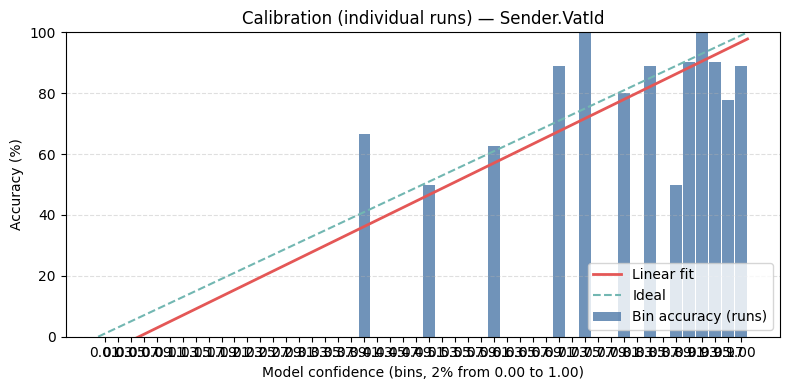

Saved: ..\Output\2025-09-12_10-59-39\calibration_runs_Sender_VatId_0_100_2pct.png


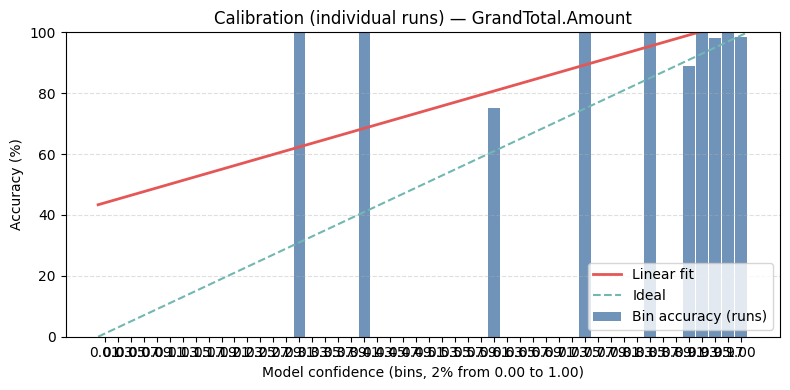

Saved: ..\Output\2025-09-12_10-59-39\calibration_runs_GrandTotal_Amount_0_100_2pct.png


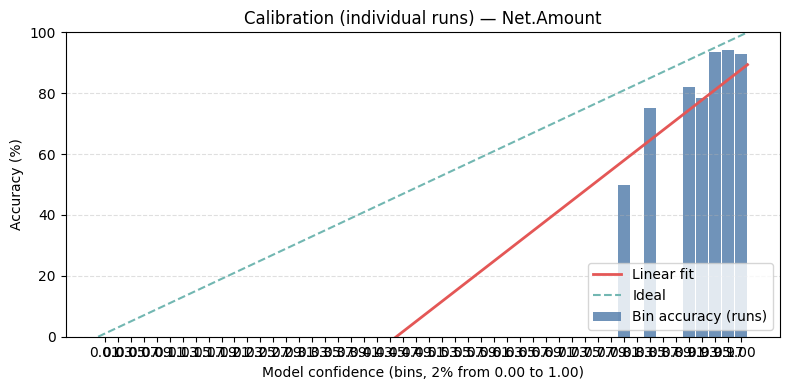

Saved: ..\Output\2025-09-12_10-59-39\calibration_runs_Net_Amount_0_100_2pct.png


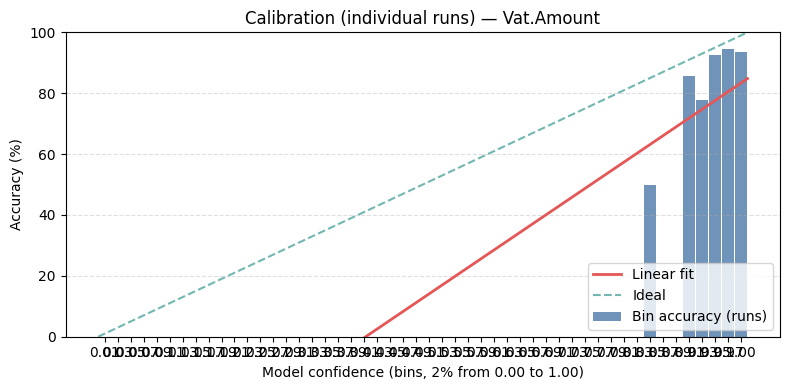

Saved: ..\Output\2025-09-12_10-59-39\calibration_runs_Vat_Amount_0_100_2pct.png


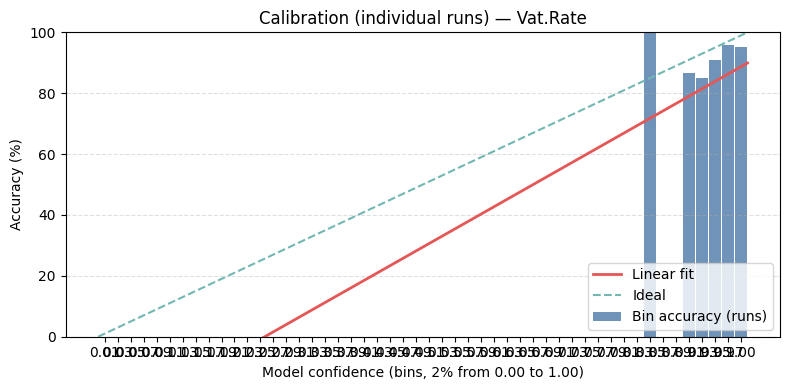

Saved: ..\Output\2025-09-12_10-59-39\calibration_runs_Vat_Rate_0_100_2pct.png


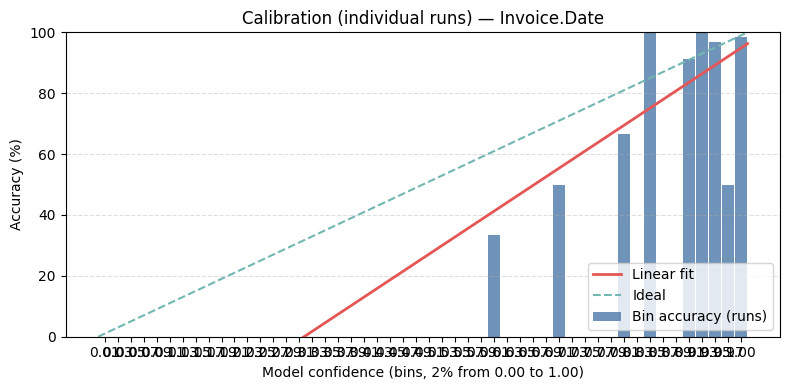

Saved: ..\Output\2025-09-12_10-59-39\calibration_runs_Invoice_Date_0_100_2pct.png


In [7]:
# 80–100% in 2% bins
FOLDER_TO_VISUALIZE = "2025-09-12_10-59-39"
plot_calibration_for_individual_runs(f"../Output/{FOLDER_TO_VISUALIZE}", min_conf=0.00, max_conf=1.00, bin_width=0.02)

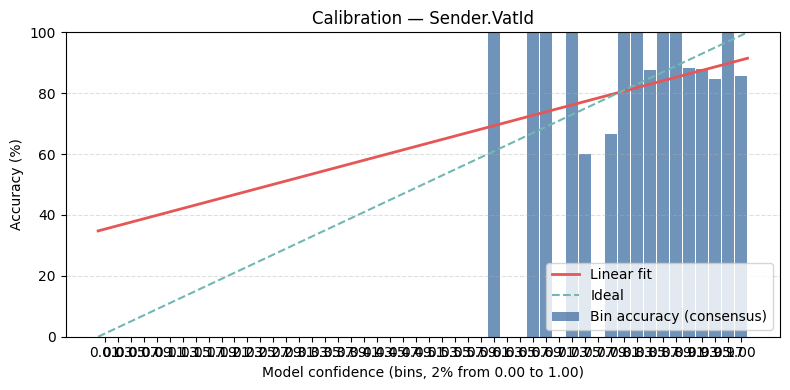

Saved: ..\Output\2025-09-12_10-59-39\calibration_Sender_VatId_0_100_2pct.png


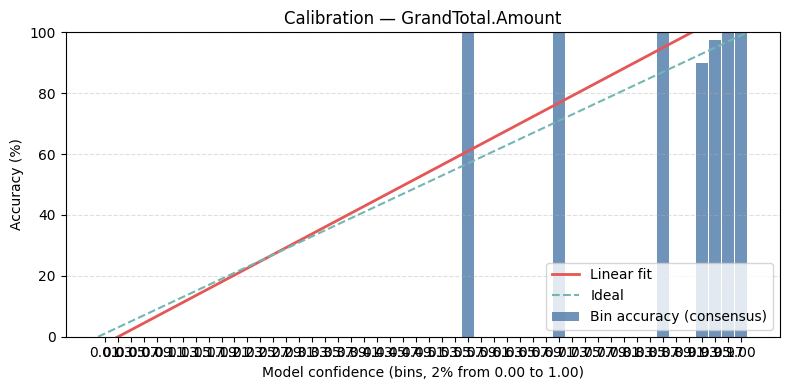

Saved: ..\Output\2025-09-12_10-59-39\calibration_GrandTotal_Amount_0_100_2pct.png


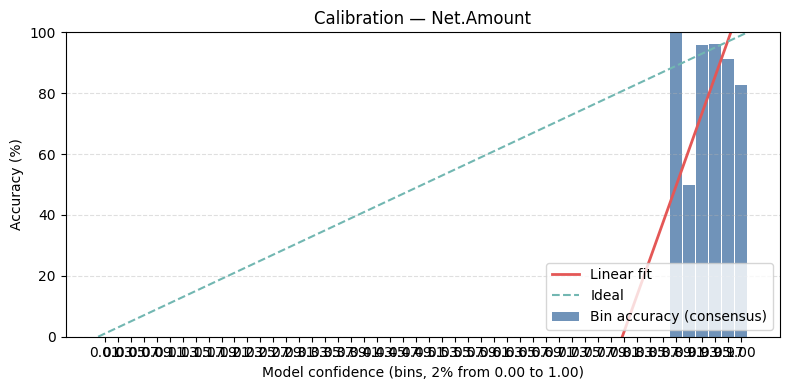

Saved: ..\Output\2025-09-12_10-59-39\calibration_Net_Amount_0_100_2pct.png


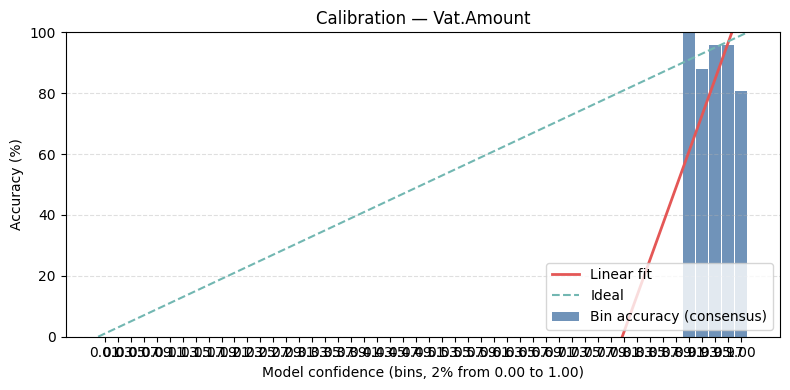

Saved: ..\Output\2025-09-12_10-59-39\calibration_Vat_Amount_0_100_2pct.png


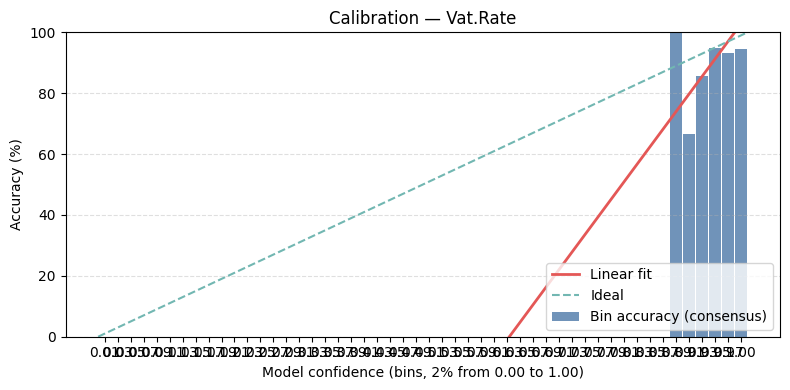

Saved: ..\Output\2025-09-12_10-59-39\calibration_Vat_Rate_0_100_2pct.png


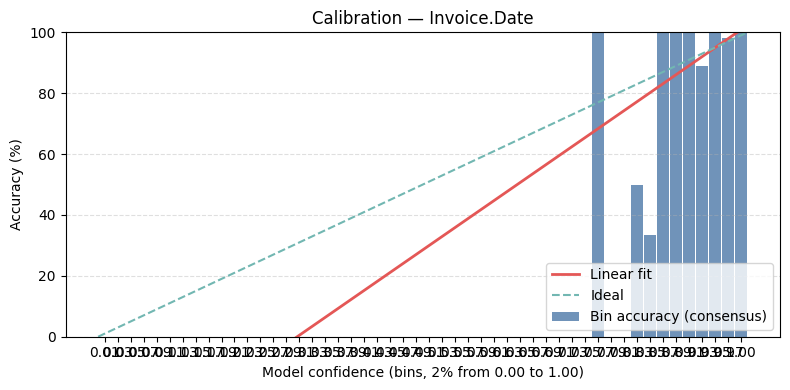

Saved: ..\Output\2025-09-12_10-59-39\calibration_Invoice_Date_0_100_2pct.png


In [8]:
plot_calibration_for_run(f"../Output/{FOLDER_TO_VISUALIZE}", min_conf=0.00, max_conf=1.00, bin_width=0.02)


In [9]:
import json
from pathlib import Path

def print_wrong_consensus(run_dir: str | Path, only_fields: list[str] | None = None):
    run_dir = Path(run_dir)
    assert run_dir.is_dir(), f"Not a directory: {run_dir}"

    consensus_files = sorted(run_dir.glob("*/consensus.json"))
    if not consensus_files:
        print(f"No consensus.json files under {run_dir}")
        return

    total_files = 0
    files_with_errors = 0
    total_errors = 0

    for cf in consensus_files:
        data = json.loads(cf.read_text(encoding="utf-8"))
        input_path = data.get("input_path")
        final_answer = data.get("final_answer", {}) or {}

        # Build flat answer dict and per-field confidence from consensus
        answer_values = {}
        per_field_conf = {}
        for field, entry in final_answer.items():
            if only_fields and field not in only_fields:
                continue
            if isinstance(entry, dict) and "value" in entry:
                answer_values[field] = entry.get("value")
                per_field_conf[field] = entry.get("avg_confidence")
            else:
                answer_values[field] = entry
                per_field_conf[field] = None

        total_files += 1

        # Evaluate vs. ground truth
        evaluation = compare_with_ground_truth(answer_values, input_path)
        per_field_eval = evaluation.get("per_field", {})
        if not per_field_eval:
            # ground truth missing or no comparable fields
            continue

        wrongs = []
        for field, triple in per_field_eval.items():
            try:
                is_match = bool(triple[0])
            except Exception:
                continue
            if not is_match:
                pred_val = answer_values.get(field)
                gt_val = triple[2]
                conf = per_field_conf.get(field)
                wrongs.append((field, pred_val, gt_val, conf))

        if wrongs:
            files_with_errors += 1
            file_id = Path(input_path).stem.split("_")[0] if input_path else cf.parent.name
            print(f"\n=== File {file_id} ===")
            for field, pred, gt, conf in wrongs:
                total_errors += 1
                print(f"- {field}")
                print(f"  predicted: {pred}")
                print(f"  ground_tr: {gt}")
                print(f"  confidence: {conf}")

    print(f"\nScanned: {total_files} files | Files with errors: {files_with_errors} | Total wrong fields: {total_errors}")

# Example:
print_wrong_consensus(f'../Output/{FOLDER_TO_VISUALIZE}')


=== File 273560 ===
- Sender.VatId
  predicted: ATU22642807
  ground_tr: ATU 43349701
  confidence: 0.94

=== File 273567 ===
- Sender.VatId
  predicted: ATU22642807
  ground_tr: ATU 31714302
  confidence: 0.95

=== File 273607 ===
- Sender.VatId
  predicted: ATU22642807
  ground_tr: ATU14391601,
  confidence: 0.79
- Net.Amount
  predicted: 73548.0
  ground_tr: ['73.548,00', '73.548,00']
  confidence: 0.96
- Vat.Amount
  predicted: 7354.8
  ground_tr: ['7.354,80', '7.354,80']
  confidence: 0.96
- Vat.Rate
  predicted: 10
  ground_tr: ['10', '10']
  confidence: 0.96

=== File 273642 ===
- Sender.VatId
  predicted: ATU22642807
  ground_tr: ATU 31714302
  confidence: 0.98

=== File 273684 ===
- Net.Amount
  predicted: 20.9
  ground_tr: ['20,90', '20,90']
  confidence: 0.97
- Vat.Amount
  predicted: 4.18
  ground_tr: ['4,18', '4,18']
  confidence: 0.97
- Vat.Rate
  predicted: 20
  ground_tr: ['20.00', '20,00']
  confidence: 0.97

=== File 273688 ===
- Invoice.Date
  predicted: 2. Nov 2023